<a href="https://www.kaggle.com/code/adrienmorel97/v1-exploratory-baseline?scriptVersionId=226777452" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import matplotlib.gridspec as gridspec
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [3]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/playground-series-s5e3/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e3/test.csv')

In [4]:
# Check dataset shape and first rows
print(f"Dataset contains {train_df.shape[0]} rows and {train_df.shape[1]} columns.")
train_df.head()

Dataset contains 2190 rows and 13 columns.


,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.5 KB


In [6]:
# Save 'id' column for submission
test_ids = test_df['id']
train_df = train_df.drop(columns=['id'])

# Define the target column
target_column = 'rainfall'

# Select categorical and numerical columns (initial)
numerical_columns = train_df.select_dtypes(exclude=['object']).columns

# Print out column information
print("Target Column:", target_column)
print("\nNumerical Columns:", numerical_columns.tolist())

Target Column: rainfall

Numerical Columns: ['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed', 'rainfall']


In [7]:
train_df.describe().round(2)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.00,2190.00,2190.00,2190.00,2190.00,2190.00,2190.00,2190.00,2190.00,2190.00,2190.00,2190.00
mean,179.95,1013.60,26.37,23.95,22.17,20.45,82.04,75.72,3.74,104.86,21.80,0.75
std,105.20,5.66,5.65,5.22,5.06,5.29,7.80,18.03,3.63,80.00,9.90,0.43
min,1.00,999.00,10.40,7.40,4.00,-0.30,39.00,2.00,0.00,10.00,4.40,0.00
25%,89.00,1008.60,21.30,19.30,17.70,16.80,77.00,69.00,0.40,40.00,14.12,1.00
50%,178.50,1013.00,27.80,25.50,23.85,22.15,82.00,83.00,2.40,70.00,20.50,1.00
75%,270.00,1017.78,31.20,28.40,26.40,25.00,88.00,88.00,6.80,200.00,27.90,1.00
max,365.00,1034.60,36.00,31.50,29.80,26.70,98.00,100.00,12.10,300.00,59.50,1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and 

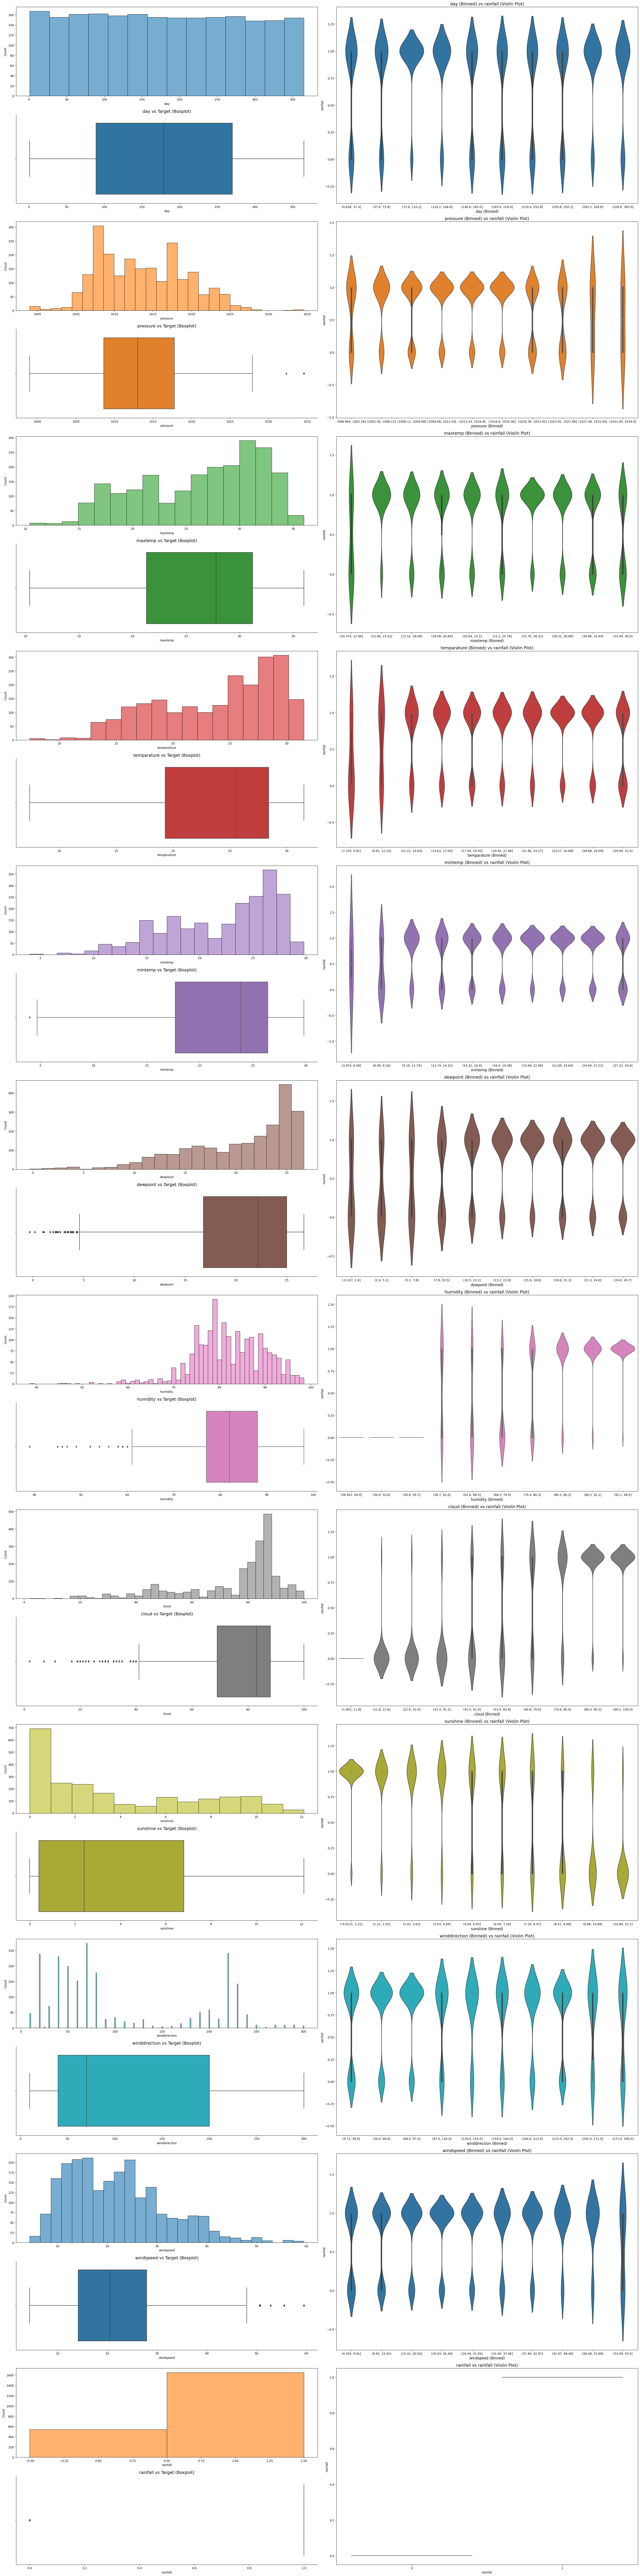

In [8]:
# Create a color palette for the columns
palette = sns.color_palette('tab10', len(numerical_columns))
color_dict = dict(zip(numerical_columns, palette))

# Create a grid of subplots for histograms, boxplots, and scatterplots/violin plots
fig = plt.figure(figsize=(30, 10 * len(numerical_columns)))
gs = gridspec.GridSpec(2 * len(numerical_columns), 2, figure=fig)

df_binned = train_df.copy()

for i, column in enumerate(numerical_columns):

    if train_df[column].nunique() > 50: discrete = False
    else : discrete = True
    
    # Plot histogram with a unique color
    ax_hist = fig.add_subplot(gs[2 * i, 0])
    sns.histplot(
        data=train_df, x=column, fill=True, common_norm=False, alpha=0.6,
        linewidth=0.8, color=color_dict[column], ax=ax_hist,  discrete = discrete
    )
    
    # Plot boxplot with the same unique color
    ax_box = fig.add_subplot(gs[2 * i + 1, 0])
    sns.boxplot(data=train_df, x=column, ax=ax_box, color=color_dict[column])
    ax_box.set_title(f'{column} vs Target (Boxplot)', fontsize=14)
    sns.despine(ax=ax_box)

    # Conditional plot: violin plot or barplot based on unique values, fallback to scatterplot
    ax_conditional = fig.add_subplot(gs[2 * i:2 * i + 2, 1])  # Merges 2 rows
    if train_df[column].nunique() <= 10:
        # If the column has 10 or fewer unique values, use a violin plot
        sns.violinplot(data=train_df, x=column, y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} vs {target_column} (Violin Plot)', fontsize=14)
    else:
        # Bin the column into 10 intervals, but keep original target column values
        df_binned['Binned Column'] = pd.cut(train_df[column], bins=10)
        sns.violinplot(data=df_binned, x='Binned Column', y=target_column, ax=ax_conditional, color=color_dict[column], alpha=0.6)
        ax_conditional.set_title(f'{column} (Binned) vs {target_column} (Violin Plot)', fontsize=14)
        ax_conditional.set_xlabel(f'{column} (Binned)', fontsize=12)

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()

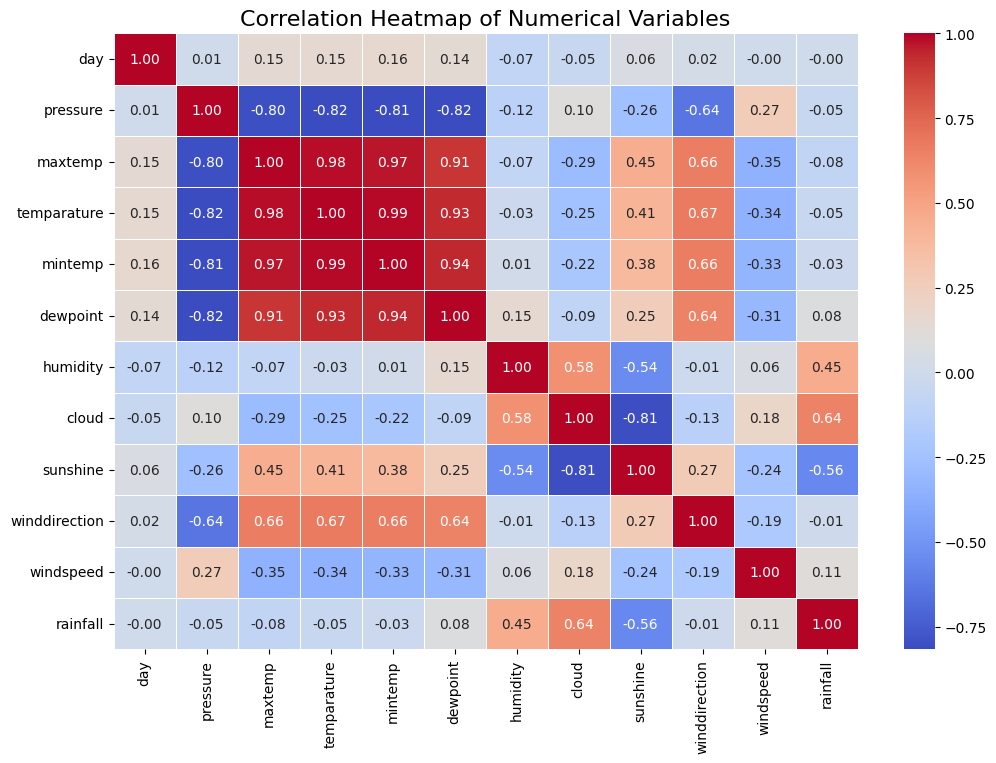

In [9]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Variables", fontsize=16)
plt.show()

In [10]:
def date(df):
    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365)  
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365)
    return df

# Apply the date function to both datasets
train_df = date(train_df)
test_df = date(test_df)

In [11]:
# Split train data into features and target
X = train_df.drop(columns=[target_column, 'day'])
y = train_df[target_column]

In [12]:
from sklearn.preprocessing import StandardScaler

preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

X_processed = preprocessor.fit_transform(X)
test_processed = preprocessor.transform(test_df.drop(columns=['id', 'day']))

In [13]:
clf = LogisticRegression(random_state=42)
clf.fit(X_processed, y)

LogisticRegression(random_state=42)

In [14]:
# Make predictions on the test set
test_predictions = clf.predict(test_processed)

# Prepare submission file
submission = pd.DataFrame({'id': test_df['id'], 'rainfall': test_predictions})
submission.to_csv("submission.csv", index=False)

<div style="background-color:purple; color:white; padding:10px; border-radius:5px;">
    📊 Dataset Overview
</div>
